In [1]:
import os
import cv2
import numpy as np

path = 'digits-dataset'
x = []
y = []

for dig in range(10):
    img_list = os.listdir(path + "/" + str(dig))
    for i in img_list:
        img = cv2.imread(path + "/" + str(dig) + "/" + i, 0)
        img = cv2.resize(img, (28,28))
        img = cv2.equalizeHist(img)
        img = img / 255.0
        x.append(img)
        y.append(dig)
        
x = np.array(x)
y = np.array(y)
x = x.reshape(x.shape[0], 28, 28, 1)

In [29]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2)


print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

#print("Number of samples from each digit:")
#for dig in range(10):
    #print(len(np.where(y_train==dig)[0]))

(6502, 28, 28, 1)
(1626, 28, 28, 1)
(2032, 28, 28, 1)


In [30]:
import tensorflow as tf
from keras import Sequential
from keras import layers
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical

img_data_gen = ImageDataGenerator(width_shift_range=0.1,
                                  height_shift_range=0.1,
                                  zoom_range=0.2,
                                  shear_range=0.1,
                                  rotation_range=10)
img_data_gen.fit(x_train)

y_train = to_categorical(y_train, 10)
y_val = to_categorical(y_val, 10)
y_test = to_categorical(y_test, 10)

def dr_model():
    model = Sequential([
    
        layers.Conv2D(60, (5,5), input_shape=(28,28,1), activation='relu'),
        layers.Conv2D(60, (5,5), activation='relu'),
        layers.MaxPooling2D(pool_size=(2,2)),
    
        layers.Conv2D(30, (3,3), activation='relu'),
        layers.Conv2D(30, (3,3), activation='relu'),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Dropout(0.5),
    
        layers.Flatten(),
        layers.Dense(500, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(10, activation='softmax')
    ])
    return model

model = dr_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 24, 24, 60)        1560      
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 20, 20, 60)        90060     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 10, 10, 60)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 8, 8, 30)          16230     
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 6, 6, 30)          8130      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 3, 3, 30)          0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 3, 3, 30)         

In [31]:
class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('accuracy') > 0.999:
            print("Quitting training because accuracy exceeded 99.9%")
            self.model.stop_training = True
        
history = model.fit(img_data_gen.flow(x_train, y_train, batch_size=50),
                    epochs=20,
                    validation_data=(x_val, y_val),
                    shuffle=1,
                    callbacks=[CustomCallback()])

Epoch 1/20
131/131 [==============================] - 16s 120ms/step - loss: 1.6101 - accuracy: 0.4119 - val_loss: 0.2409 - val_accuracy: 0.9237
Epoch 2/20
131/131 [==============================] - 16s 123ms/step - loss: 0.5900 - accuracy: 0.8071 - val_loss: 0.1041 - val_accuracy: 0.9699
Epoch 3/20
131/131 [==============================] - 17s 130ms/step - loss: 0.3519 - accuracy: 0.8842 - val_loss: 0.0728 - val_accuracy: 0.9766
Epoch 4/20
131/131 [==============================] - 17s 129ms/step - loss: 0.2823 - accuracy: 0.9097 - val_loss: 0.0564 - val_accuracy: 0.9828
Epoch 5/20
131/131 [==============================] - 17s 129ms/step - loss: 0.2277 - accuracy: 0.9245 - val_loss: 0.0475 - val_accuracy: 0.9840
Epoch 6/20
131/131 [==============================] - 17s 129ms/step - loss: 0.1884 - accuracy: 0.9397 - val_loss: 0.0442 - val_accuracy: 0.9840
Epoch 7/20
131/131 [==============================] - 17s 130ms/step - loss: 0.1700 - accuracy: 0.9436 - val_loss: 0.0442 - val_ac

In [32]:
test_predict = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", test_predict[0])
print("Test accuracy:", test_predict[1])

Test loss: 0.020588591694831848
Test accuracy: 0.9926180839538574


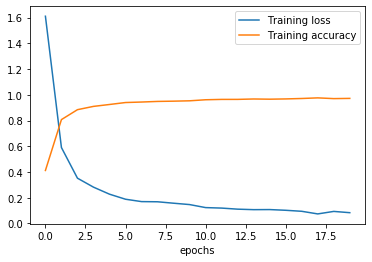

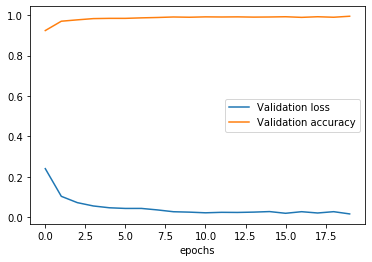

In [33]:
import matplotlib.pyplot as plt

plt.figure(1)
plt.plot(history.history['loss'])
plt.plot(history.history['accuracy'])
plt.legend(['Training loss', 'Training accuracy'])
plt.xlabel('epochs')

plt.figure(2)
plt.plot(history.history['val_loss'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Validation loss', 'Validation accuracy'])
plt.xlabel('epochs')

plt.show()

In [35]:
model.save('dr_model.h5')